In [1]:
import rospy
import rospkg

from real_time_simulator.msg import FSM
from real_time_simulator.msg import State
from real_time_simulator.msg import Control
from real_time_simulator.msg import Sensor
from real_time_simulator.msg import Trajectory
from real_time_simulator.msg import Waypoint

import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

import time


import rosbag
from scipy import integrate

%matplotlib notebook
#%matplotlib inline
plt.rcParams.update({'font.size': 18})

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [2]:
tStart = -1
tEnd = 60

# Received sensor values
accelerometer_IMU = []
gyroscope_IMU = []
barometer = []
time_sensor = []

# Estimated state from Navigation
position_est = np.zeros((1,3))
speed_est = np.zeros((1,3))
attitude_est = np.zeros((1,4))
omega_est = np.zeros((1,3))
prop_mass_est = np.zeros((1,1))
time_state_est = np.zeros((1,1))

# Controled forces and torque
control_force = np.zeros((1,3))
z_torque = np.zeros((1,1))
time_force = np.zeros((1,1))

# Guidance optimal trajectory
target_positionZ = []
target_speedZ = []
target_prop_mass = []
time_target = [] 
thrust_target = []

rospack = rospkg.RosPack()
bag = rosbag.Bag(rospack.get_path('generic_gnc') + '/log/log_kalman_statique_2/log.bag')

for topic, msg, t in bag.read_messages(topics=['/gnc_fsm_pub']):
    if msg.state_machine == "Rail":
        time_init = t.to_sec()
    break

for topic, msg, t in bag.read_messages(topics=['/sensor_pub']):
    new_acc = msg.IMU_acc
    new_gyro = msg.IMU_gyro
    new_baro = msg.baro_height

    accelerometer_IMU.append([new_acc.x, new_acc.y, new_acc.z])
    gyroscope_IMU.append([new_gyro.x, new_gyro.y, new_gyro.z])
    barometer.append(new_baro)
    time_sensor.append(t.to_sec())

for topic, msg, t in bag.read_messages(topics=['/kalman_rocket_state']):
    new_pos = msg.pose.position
    new_speed = msg.twist.linear
    new_attitude = msg.pose.orientation    
    new_omega = msg.twist.angular
    new_mass = msg.propeller_mass
        
    position_est = np.append(position_est, [[new_pos.x, new_pos.y, new_pos.z]], axis = 0)
    speed_est = np.append(speed_est, [[new_speed.x, new_speed.y, new_speed.z]], axis = 0)
    attitude_est = np.append(attitude_est, [[ new_attitude.x, new_attitude.y, new_attitude.z, new_attitude.w]], axis = 0)
    omega_est = np.append(omega_est, [[new_omega.x, new_omega.y, new_omega.z]], axis = 0)
    prop_mass_est = np.append(prop_mass_est, [[new_mass]])
    time_state_est = np.append(time_state_est, [[t.to_sec()]])

for topic, msg, t in bag.read_messages(topics=['/control_pub']):
    new_force = msg.force
    control_force = np.append(control_force, [[new_force.x, new_force.y, new_force.z]], axis = 0)
    z_torque = np.append(z_torque, [[msg.torque.z]]) 
    time_force = np.append(time_force, [[t.to_sec()]]) 
    
for topic, msg, t in bag.read_messages(topics=['/target_trajectory']):
    new_waypoint = msg.trajectory

    time_target.append([point.time for point in new_waypoint])
    target_positionZ.append([point.position.z for point in new_waypoint])
    target_speedZ.append([point.speed.z for point in new_waypoint])
    target_prop_mass.append([point.propeller_mass for point in new_waypoint])
    thrust_target.append([point.thrust for point in new_waypoint])
    
bag.close()

# Convert to numpy array
time_target = np.array(time_target)
target_positionZ = np.array(target_positionZ)
target_speedZ = np.array(target_speedZ)
target_prop_mass = np.array(target_prop_mass)
thrust_target = np.array(thrust_target)

accelerometer_IMU = np.array(accelerometer_IMU)
gyroscope_IMU = np.array(gyroscope_IMU)
barometer = np.array(barometer)
time_sensor = np.array(time_sensor)

# Only keep ROS data

prop_mass_est = prop_mass_est[1:]
speed_est = speed_est[1:]
omega_est = omega_est[1:]
position_est = position_est[1:]
attitude_est = attitude_est[1:]
time_state_est = time_state_est[1:]

control_force = control_force[1:]
z_torque = z_torque[1:]
time_force = time_force[1:]


# Synchronize time
time_force = time_force - time_init
time_sensor = time_sensor - time_init
time_state_est = time_state_est - time_init

# Convert quaternion to euler for easier visualization
quaternion_est = attitude_est
r = R.from_quat(attitude_est)
attitude_est = r.as_euler('zyx', degrees=True)

# Convert radians to degrees for easier visualization
omega_est = np.rad2deg(omega_est)

select_est = np.logical_and(time_state_est>tStart, time_state_est <tEnd)
select_sensor = np.logical_and(time_sensor>tStart, time_sensor <tEnd)
select_force = np.logical_and(time_force>tStart, time_force <tEnd) 
select_target = np.zeros_like(time_target, dtype = bool)

<IPython.core.display.Javascript object>


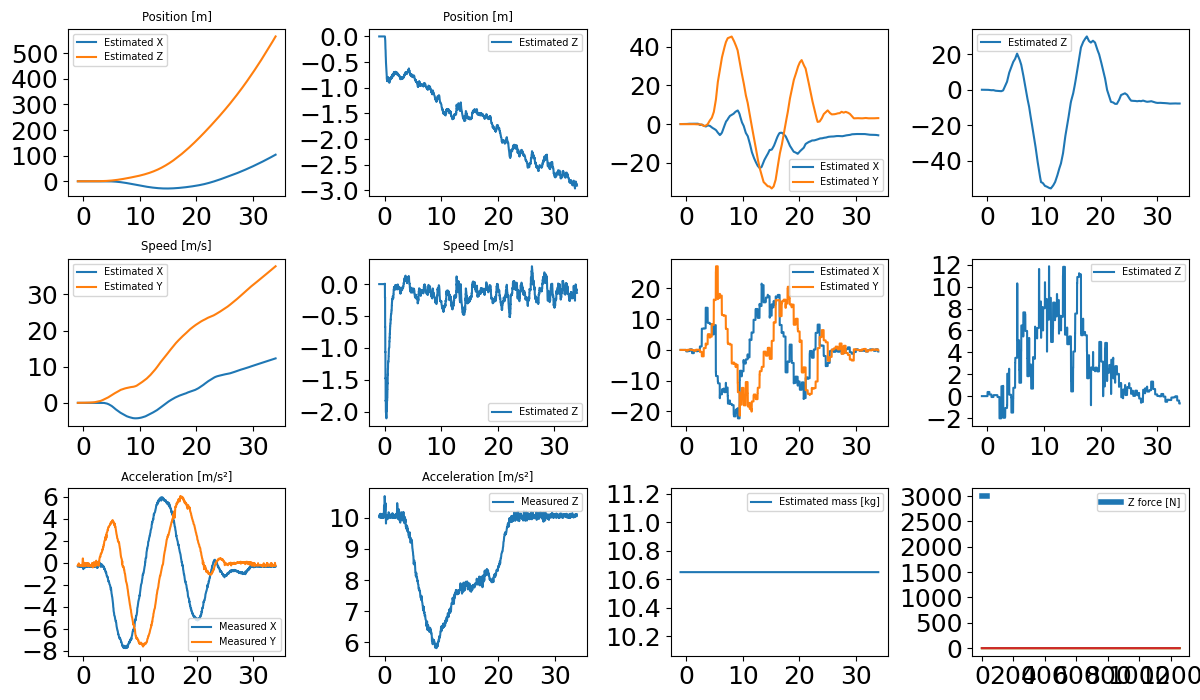

In [3]:
fig, axe = plt.subplots(3,4, figsize=(12,7))

plt.rcParams.update({'font.size': 7})

# Plot Navigation estimated state
l = axe[0][0].plot(time_state_est[select_est], position_est[:, 0][select_est], label = 'Estimated X')
l = axe[0][0].plot(time_state_est[select_est], position_est[:, 1][select_est], label = 'Estimated Z')
axe[0][0].set_title('Position [m]')
axe[0][0].legend()

l = axe[0][1].plot(time_state_est[select_est], position_est[:, 2][select_est], label = 'Estimated Z')
axe[0][1].set_title('Position [m]')
axe[0][1].legend()

l = axe[1][0].plot(time_state_est[select_est], speed_est[:, 0][select_est], label = 'Estimated X')
l = axe[1][0].plot(time_state_est[select_est], speed_est[:, 1][select_est], label = 'Estimated Y')
axe[1][0].set_title('Speed [m/s]')
axe[1][0].legend()

l = axe[1][1].plot(time_state_est[select_est], speed_est[:, 2][select_est], label = "Estimated Z")
axe[1][1].set_title('Speed [m/s]')
axe[1][1].legend()

l = axe[2][0].plot(time_sensor[select_sensor], accelerometer_IMU[:, 0][select_sensor], label = "Measured X")
l = axe[2][0].plot(time_sensor[select_sensor], accelerometer_IMU[:, 1][select_sensor], label = "Measured Y")
axe[2][0].set_title('Acceleration [m/s²]')
axe[2][0].legend()

l = axe[2][1].plot(time_sensor[select_sensor], accelerometer_IMU[:, 2][select_sensor], label = "Measured Z")
axe[2][1].set_title('Acceleration [m/s²]')
axe[2][1].legend()

l = axe[0][2].plot(time_state_est[select_est], attitude_est[:, 0][select_est], label = "Estimated X")
l = axe[0][2].plot(time_state_est[select_est], attitude_est[:, 1][select_est], label = "Estimated Y")
axe[0][2].legend()

l = axe[0][3].plot(time_state_est[select_est], attitude_est[:, 2][select_est], label = "Estimated Z")
axe[0][3].legend()  

l = axe[1][2].plot(time_state_est[select_est], omega_est[:, 0][select_est], label = "Estimated X")
l = axe[1][2].plot(time_state_est[select_est], omega_est[:, 1][select_est], label = "Estimated Y")
axe[1][2].legend()

l = axe[1][3].plot(time_state_est[select_est], omega_est[:, 2][select_est], label = "Estimated Z")
axe[1][3].legend()

l = axe[2][2].plot(time_state_est[select_est], prop_mass_est[select_est], label = "Estimated mass [kg]")
axe[2][2].legend()

# Plot simulated data as reference
#l = axe[2][2].plot(time_sensor[select_sensor], gyroscope_IMU[:, 0][select_sensor], label = "X")
#l = axe[2][2].plot(time_sensor[select_sensor], gyroscope_IMU[:, 1][select_sensor], label = "Y")
#axe[2][2].set_title('Gyroscope measurement [rad/s]')
#axe[2][2].legend()

#l = axe[2][3].plot(time_sensor[select_sensor], gyroscope_IMU[:, 2][select_sensor], label = "Z")
#axe[2][3].legend()

l = axe[2][3].plot(time_force[select_force], control_force[:, 2][select_force], label = "Z force [N]", linewidth=4)
axe[2][3].legend()

fig.tight_layout()

<IPython.core.display.Javascript object>


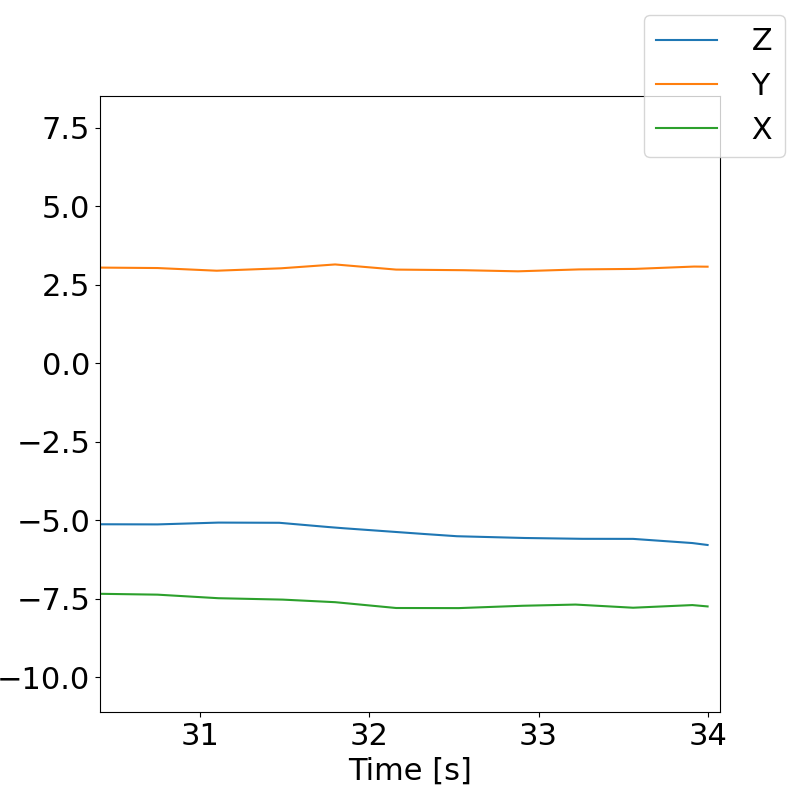

In [30]:
plt.rcParams.update({'font.size': 22})
fig = plt.figure(figsize=(8,8))
plt.plot(time_state_est[select_est], attitude_est[:, 0][select_est], label = " Z")
plt.plot(time_state_est[select_est], attitude_est[:, 1][select_est], label = " Y")
plt.plot(time_state_est[select_est], attitude_est[:, 2][select_est], label = " X")

plt.xlabel("Time [s]")
plt.ylabel("Euler angle [°]")
fig.legend()
#np.mean(np.gradient(barometer, time_sensor))

<IPython.core.display.Javascript object>


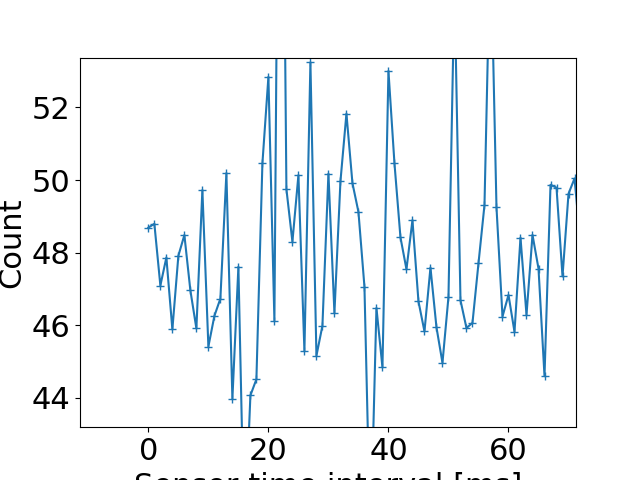

0.04788934748830193

In [14]:
plt.plot(1000*np.diff(time_sensor)[np.diff(time_sensor)>40e-3], marker = "+")
plt.xlabel("Sensor time interval [ms]")
plt.ylabel("Count")
np.mean(np.diff(time_sensor)[np.diff(time_sensor)>40e-3])

<IPython.core.display.Javascript object>


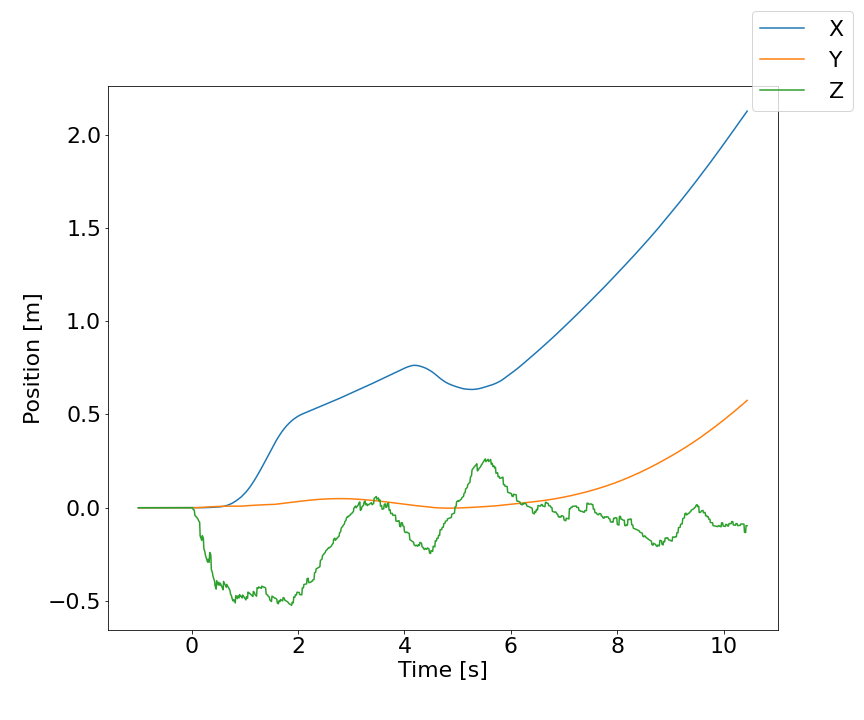

In [78]:
plt.rcParams.update({'font.size': 22})
fig = plt.figure(figsize=(12,10))
plt.plot(time_state_est[select_est], position_est[:, 0][select_est], label = " X")
plt.plot(time_state_est[select_est], position_est[:, 1][select_est], label = " Y")
plt.plot(time_state_est[select_est], position_est[:, 2][select_est], label = " Z")

plt.xlabel("Time [s]")
plt.ylabel("Position [m]")
fig.legend()

<IPython.core.display.Javascript object>


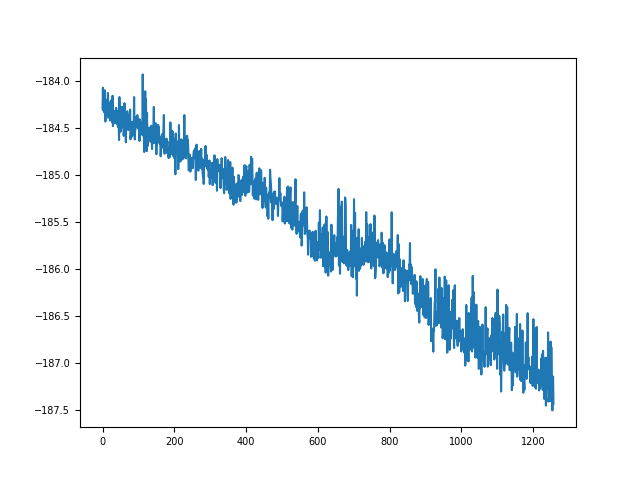

In [14]:
plt.plot(barometer)

(-5.0, 5.0)

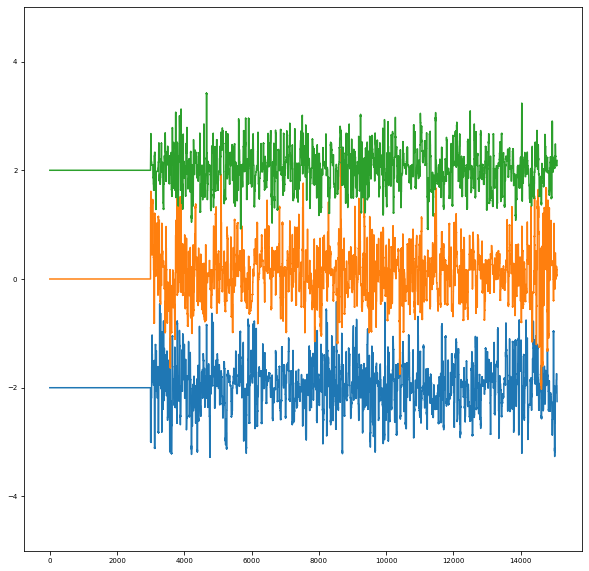

In [4]:
euler_grad = [np.gradient(attitude_est[:, 0], time_state_est)-2,
              np.gradient(attitude_est[:, 1], time_state_est),
              np.gradient(attitude_est[:, 2], time_state_est)+2]
plt.figure(figsize=(10,10))
plt.plot(np.transpose(euler_grad))
plt.ylim([-5, 5])

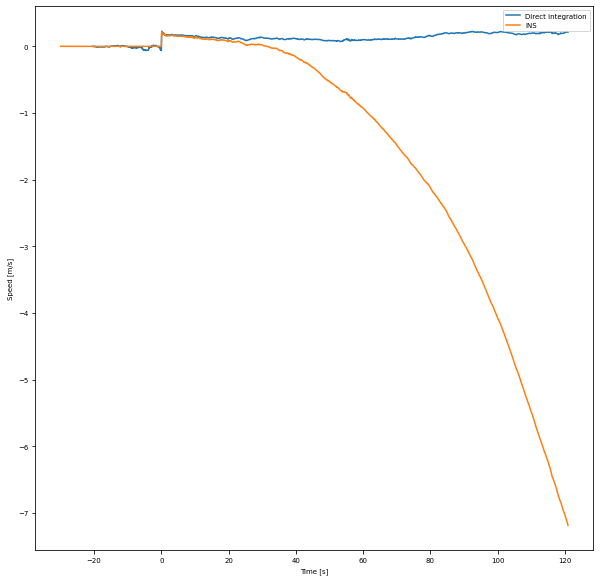

In [7]:

bias = np.sum(accelerometer_IMU[:1000,2])/1000
speed_IMU = integrate.cumulative_trapezoid(accelerometer_IMU[:,2] - bias, time_sensor, initial = 0)

plt.figure(figsize=(10,10))
plt.plot(time_sensor, speed_IMU)
plt.plot(time_state_est, speed_est[:, 2])
plt.xlabel("Time [s]")
plt.ylabel("Speed [m/s]")
plt.legend(["Direct integration", "INS"])

In [15]:
(np.std(barometer[:300], axis = 0))


0.2181128063897196

In [9]:
bias = np.array([0.0186101, -0.101785, -0.0419259, -0.30663, -0.0421702, -0.0596358, -0.0799601, -0.0703616, -0.0219077, -0.116608])
np.mean(bias)

-0.08223742

In [13]:
bias = np.array([-0.035447, -0.105165, -0.0286149, 0.182194, -0.0996915, 0.00886979, -0.0159661, 0.140706, 0.0685335])
np.std(bias)*3

0.28216390730137547

In [11]:
1.42 47.63 1.00 0.00000 0.00000 0.23 6.84 4.60 4.20 3.66 -35.6 -2.4 -0.7 0.3 0.1 0.0 -2.8 
2.82 5.68 1.49 0.00000 0.00000 0.58 3.35 2.33 4.21 3.66 -21.0 -1.5 -0.2 0.2 0.1 0.0 -2.1 
3.54 158.86 1.53 0.00000 0.00000 0.15 6.59 1.02 4.27 3.62 13.2 0.4 0.4 -0.0 -0.0 -0.0 0.6 
7.56 59.10 0.45 0.00000 0.00000 0.93 0.79 3.73 4.30 3.67 -1.0 -1.7 -2.6 -0.9 0.1 0.1 -0.6 
0.27 94.80 9.34 0.00000 0.00000 0.63 4.09 5.28 4.42 3.65 37.3 -1.8 0.3 -0.1 0.1 -0.0 2.3 
9.97 126.29 14.37 0.00000 0.00000 0.77 7.26 3.65 4.58 3.77 -13.3 5.0 -5.7 -0.1 -0.2 0.3 -1.8 
5.85 25.95 1.67 0.00000 0.00000 0.16 6.04 9.82 4.02 3.64 1.5 -0.1 1.5 0.1 0.1 -0.1 -0.2 
2.53 99.44 0.31 0.00000 0.00000 0.86 3.88 5.54 4.44 3.66 -11.6 -0.4 -0.4 -0.8 0.0 0.0 -1.4 
4.59 82.56 6.72 0.00000 0.00000 0.84 6.41 3.60 4.36 3.68 4.3 0.2 -0.8 -0.4 -0.0 0.0 -0.1 
2.47 43.48 8.29 0.00000 0.00000 0.64 1.02 4.65 4.49 3.70 10.3 2.8 0.4 0.2 -0.0 0.0 0.1 

2.0479205019999998

In [12]:
3*0.3/np.sqrt(100)

0.09